# Modelo: Transformers (DistilBERT o RoBERTa)

In [1]:
import os, time, gc, random, math
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset as HFDataset
import evaluate as hf_evaluate


In [2]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
set_seed()

# Fuerza CPU (por si acaso)
torch.cuda.is_available = lambda: False
DEVICE = "cpu"

BASE_DIR   = os.getcwd()
CACHE_DIR  = os.path.join(BASE_DIR, "models_cache")
OUTPUT_DIR = os.path.join(BASE_DIR, "hf_out_distilbert_cpu")

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

MODEL_NAME = "distilbert-base-uncased"
print(f"✅ Dispositivo: {DEVICE}")

✅ Dispositivo: cpu


In [3]:
PATH = "dataset_EDA_completo.csv"
df = pd.read_csv(PATH)

# Nos quedamos con texto y target
df = df[['clean_text', 'category']].dropna()
df = df[df['clean_text'].str.strip().str.len() > 0].copy()

# Label encoding
le = LabelEncoder()
df['y'] = le.fit_transform(df['category'])
classes = list(le.classes_)
num_classes = len(classes)

# Split 70/15/15 estratificado
X_train, X_tmp, y_train, y_tmp = train_test_split(
    df['clean_text'], df['y'], test_size=0.30, random_state=SEED, stratify=df['y']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp
)
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)} | Clases: {num_classes}")

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_EDA_completo.csv'

In [8]:
# ======================================================
# ✏️ TOKENIZACIÓN Y DATASETS
# ======================================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

train_ds = HFDataset.from_dict({"text": list(X_train), "labels": list(y_train)})
val_ds   = HFDataset.from_dict({"text": list(X_val),   "labels": list(y_val)})
test_ds  = HFDataset.from_dict({"text": list(X_test),  "labels": list(y_test)})

train_ds = train_ds.map(tok, batched=True)
val_ds   = val_ds.map(tok, batched=True)
test_ds  = test_ds.map(tok, batched=True)

cols = ['input_ids', 'attention_mask', 'labels']
for ds in (train_ds, val_ds, test_ds):
    ds.set_format(type='torch', columns=cols)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1904 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

In [9]:
# ======================================================
# 🧠 MODELO (CPU)
# ======================================================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_classes, cache_dir=CACHE_DIR
)
model.to(DEVICE)

# ======================================================
# 📊 MÉTRICAS PARA TRAINER (simple)
# ======================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
    }


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# ======================================================
# ⚙️ ARGUMENTOS (solo CPU)
# ======================================================
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",          # tu versión usa este nombre
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,  # batch más pequeño en CPU
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to=None,
    fp16=False,                     # sin mixed precision en CPU
    optim="adamw_torch"             # optim estándar para CPU
)

# ======================================================
# 🏋️ ENTRENADOR + TIEMPO
# ======================================================
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipykernel_213787/829221557.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
t0 = time.time()
trainer.train()
t1 = time.time()
train_time_s = round(t1 - t0, 2)
print(f"\n⏱️ Tiempo total de entrenamiento (CPU): {train_time_s} s\n")


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,2.342800,1.203412,0.759804,0.770201,0.757719,0.731719
2,0.931300,0.721423,0.840686,0.837656,0.839554,0.832391
3,0.581000,0.635688,0.857843,0.856037,0.855676,0.851039



⏱️ Tiempo total de entrenamiento (CPU): 876.43 s



In [15]:

# ======================================================
# 🧪 PREDICCIÓN EN TEST
# ======================================================
pred = trainer.predict(test_ds)
logits = pred.predictions
y_pred = logits.argmax(axis=-1)

# Probabilidades para ROC-AUC (OvR) si es multiclass
y_proba = torch.softmax(torch.tensor(logits), dim=1).numpy()

# ======================================================
# 🧮 MÉTRICAS COMPLETAS + TABLA
# ======================================================
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)
cm = confusion_matrix(y_test, y_pred, labels=list(range(num_classes)))

metrics = {
    "Accuracy": acc,
    "Precision (Macro)": prec,
    "Recall (Macro)": rec,
    "F1-Score (Macro)": f1,
    "Train Time (s)": train_time_s
}

# ROC-AUC (one-vs-rest) si aplica (>=2 clases)
try:
    if num_classes > 1:
        y_true_ovr = np.eye(num_classes)[np.array(y_test)]
        from sklearn.metrics import roc_auc_score
        auc_ovr = roc_auc_score(y_true_ovr, y_proba, average="macro", multi_class="ovr")
        metrics["ROC-AUC (OvR)"] = auc_ovr
except Exception as e:
    print(f"⚠️ ROC-AUC no disponible: {e}")

df_metrics = pd.DataFrame([metrics])
print("✅ Resultados finales (CPU):")
print(df_metrics)

# (Opcional) guarda CSV
df_metrics.to_csv(os.path.join(OUTPUT_DIR, "resultados_distilbert_cpu.csv"), index=False)


✅ Resultados finales (CPU):
   Accuracy  Precision (Macro)  Recall (Macro)  F1-Score (Macro)  \
0  0.811275           0.802119        0.808768          0.799053   

   Train Time (s)  ROC-AUC (OvR)  
0          876.43       0.967794  


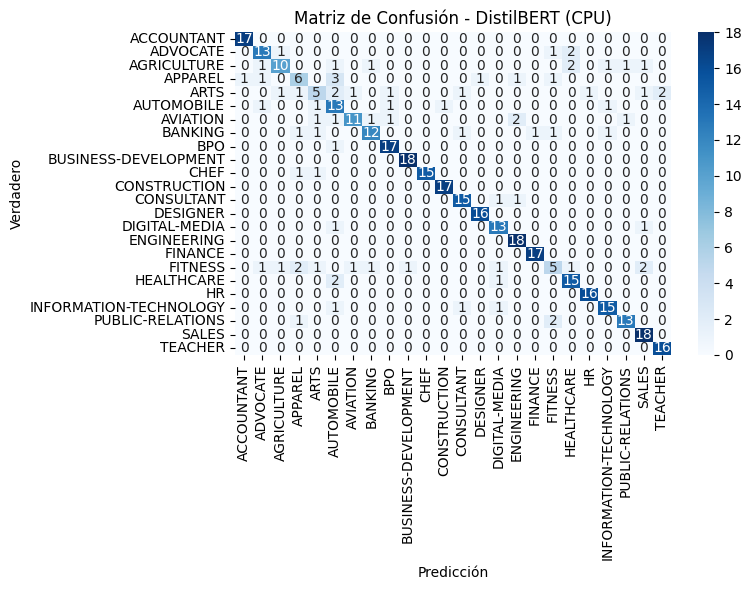

40583

In [13]:
# ======================================================
# 🔷 MATRIZ DE CONFUSIÓN
# ======================================================
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Matriz de Confusión - DistilBERT (CPU)")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.tight_layout()
plt.show()

# Limpieza ligera de memoria
gc.collect()